# Mean-Variance Portfolio Selection Strategies

#### The purpose of this project is to compare computational investment strategies based on minimizing portfolio variance and maximizing Sharpe ratio. You will need to take into account the effect of trading costs.

The goal of your optimization effort is to create a tool that allows the user to make regular decisions about re-balancing their portfolio and compare different investment strategies. The user wants to consider the total return, the risk and Sharpe ratio. They may want to minimize/maximize any of these components, while limiting one or more of the other components. The basic building block is a decision made at the first trading day of each 2-month holding period: given a current portfolio, the market prices on that day, and the estimates of the mean and covariance of the daily returns, make a decision about what to buy and sell according to a strategy. You are proposed to test four strategies:
  1. “Buy and hold” strategy;
  2. “Equally weighted” (also known as “1/n”) portfolio strategy; 
  3. “Minimum variance” portfolio strategy;
  4. “Maximum Sharpe ratio” portfolio strategy.

In [305]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cvxpy as cp
import cplex
import matplotlib.pyplot as plt

### 1. Buy and hold strategy: 
**It is the simplest strategy where you hold initial portfolio for the entire investment horizon of 2 years. The strategy is already implemented in the function strat_buy_and_hold.**

In [306]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    portfolio_value = np.sum(x_optimal*cur_prices) + cash_optimal
    w_optimal = (x_optimal*cur_prices)/portfolio_value
    return x_optimal, cash_optimal,w_optimal

### 2. “Equally weighted” (also known as “1/n”) portfolio strategy: 

**Asset weights are selected as wi = 1/n, where n is the number of assets. You may need to re-balance your portfolio in each period as the number of shares xi changes even when wi = 1/n stays the same in each period. The strategy should be implemented in the function strat_equally_weighted.**

In [319]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    n=20
    # Lets start calcuating the total value of a portfolio
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
    #Equally allocate the total money to each investment.
    allocated_money = np.array(n *[portfolio_value/20]) #Note: the list "[single value]" x a = expand the list for a times. 
    # Calculate the optimal number of investments 
    x_optimal = np.floor(allocated_money/cur_prices)
    # calculate the transcation cost during rebalancing (occurs on both buying and selling)
    trans_cost = np.dot(cur_prices,abs(x_optimal-x_init))*0.005
    # Calculate the new portfolio value with x_optimal
    portfolio_value_new = np.sum(x_optimal*cur_prices)
    # Cash = Old portfolio value - new portfolio value - Transation Cost
    cash_optimal = portfolio_value - portfolio_value_new - trans_cost
    #Calcuate the weights for each investment
    w_optimal = (x_optimal*cur_prices)/portfolio_value
    return x_optimal,cash_optimal,w_optimal


### 3. “Minimum variance” portfolio strategy: 

**Compute minimum variance portfolio for each period and re-balance accordingly. The strategy should be implemented in the function strat_min_variance.**

In [320]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # Calculate the original portfolio value
    portfolio_value = np.sum(x_init*cur_prices) + cash_init
   
   #Initialize cplex object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    n = 20 # number of stocks
    c = [0.0] * n # coefficients of linear variables from obj func
    lb = [0.0] * n # lower bound is 0 (don't want negative values)
    ub = [1.0] * n # upper bound is 1
    A = [] # initiate matrix A for coeff's of linear constraints
    
    for k in range(n):
        A.append([[0],[1]]) #one constraint on weights to minimize variance
    
    var_names = ["w_%s" %i for i in range (1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0],senses="EE")
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A,names=var_names)
    
    #Define quadratic part of obj function
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    
    #Set CPLEX parameters
    cpx.parameters.threads.set(6)
    
    #Solve model
    cpx.set_results_stream(None) # Disable CPLEX output to screen
    cpx.set_warning_stream(None)
    cpx.solve()
    
    # Extract the weight at minimum variance
    w_minVar = np.asarray(cpx.solution.get_values())
    
    #Implement equal weights for all 20 stocks
    allocated_money = w_minVar*portfolio_value
    #Calculate x_optimal value
    x_optimal = np.floor(allocated_money/cur_prices)
    #Account for the transaction cost
    transaction_cost = np.dot(cur_prices,abs(x_optimal-x_init))*0.005
    #New portfolio value with new x_optimal
    portfolio_value_new = np.sum(x_optimal*cur_prices)
    #Subtract new value of portfolio and transaction cost from original portfolio
    cash_optimal = portfolio_value - np.sum(x_optimal*cur_prices) - transaction_cost
    
    return x_optimal, cash_optimal,w_minVar

### 4. “Maximum Sharpe ratio” portfolio strategy.
**compute a portfolio that maximizes Sharpe ratio for each period and re-balance accordingly. The strategy should be implemented in the function strat_max_Sharpe.**

In [321]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    #Initialize cplex object
    n = len(x_init) +1
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Define linear part of objective function and bounds on variables
    c = [0.0]* n
    lb = [0.0] * n
    ub = [np.inf] * n
    daily_r_rf = 1.025 ** (1.0/252) -1 #convert annual rate of return to daily, assuming 252 trading days/year
    diff = mu - daily_r_rf
    
    coe_k = np.zeros((20,1))
    Q = np.hstack((Q,coe_k))
    coe_k = np.zeros((1,21))
    Q = np.vstack((Q,coe_k))
    
    #initiate matrix A for coeff's of linear constraints
    #coeff's of linear constraints are sum(mu(i)-rf)*y(i))=1 and sum(y(i))-k=0
    A = [] 
    for k in range(20):
        A.append([[0,1],[diff[k],1]])
    A.append([[0,1],[0,-1]])
    
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,0], senses="EE")  #equality constraints
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # Define and add quadratic part of objective function
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #Qmat with extra column and row of 0's to account for k
    cpx.objective.set_quadratic(Qmat)
    cpx.parameters.threads.set(6)
    
     # Optimize the problem
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    
    # Store the solution
    w_optimal = np.asarray(cpx.solution.get_values())                         
    w_maxSharpe = w_optimal[0:20]/w_optimal[20]  #w = y/k
    
    # Calculate the original portfolio value
    portfolio_value = np.sum(x_init * cur_prices) + cash_init
    # Implement weights for all 20 stocks
    allocated_money = w_maxSharpe * portfolio_value
    #Calculate x_optimal value
    x_optimal = np.floor(allocated_money/cur_prices)
    #Calculate initial x_optimal value
    transaction_cost = np.dot(cur_prices,abs(x_optimal - x_init))*0.005
    #New portfolio value with new x_optimal
    portfolio_value_new = np.sum(x_optimal*cur_prices)
    # Total Portfolio Value  = Stock Value + Optimal Cash + Transaction Cost
    cash_optimal = portfolio_value - np.sum(x_optimal * cur_prices) - transaction_cost
    
    return x_optimal, cash_optimal,w_maxSharpe


### The initial portfolio is as follows: 
**“MSFT” = 5000 shares, “F” = 950 shares, “CRAY” = 2000 shares, “VZ” = 2000 shares, “AAPL” = 3000 shares, “IBM” = 1500 shares, “NVDA” = 1001 shares.**

In [322]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)
print(df.shape)
df.head()

(545, 21)


,Date,MSFT,F,CRAY,GOOG,HPQ,YHOO,HOG,VZ,AAPL,...,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
0,11/3/2014,47.439999,13.99,34.119999,553.699829,16.285194,46.340000,65.279999,50.389999,109.400002,...,34.840000,24.580000,17.270000,34.310001,2.87,20.160000,19.870001,305.720001,34.709999,38.470001
1,11/4/2014,47.570000,13.95,34.270000,552.592834,16.303360,47.080002,64.110001,50.330002,108.599998,...,34.790001,24.879999,17.209999,34.540001,2.83,20.010000,20.129999,302.809998,34.660000,38.700001
2,11/5/2014,47.860001,13.94,33.889999,544.425293,16.430517,47.459999,64.360001,50.340000,108.860001,...,34.919998,25.150000,17.340000,33.759998,2.80,20.180000,20.129999,296.519989,34.900002,38.669998
3,11/6/2014,48.700001,14.19,34.150002,540.555908,16.416893,47.930000,65.709999,50.279999,108.699997,...,34.720001,25.260000,17.360001,33.820000,2.76,19.700001,20.219999,296.640015,35.310001,38.770000
4,11/7/2014,48.680000,14.17,33.919998,539.528748,16.521345,48.549999,66.040001,50.860001,109.010002,...,34.910000,25.330000,17.360001,33.580002,2.78,19.620001,19.790001,299.859985,35.660000,38.910000


In [323]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
print('dates_array Shape:',dates_array.shape)
print('Date Shape:',dates.shape)
print('data_prices:',data_prices.shape)

dates_array Shape: (545, 3)
Date Shape: (545,)
data_prices: (545, 20)


In [324]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])# len = 41 (2014) 
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)
print('cur_returns0 Shape:', cur_returns0.shape)
print('Q Shape:', Q.shape)
print('mu Shape:', mu.shape)

cur_returns0 Shape: (40, 20)
Q Shape: (20, 20)
mu Shape: (20,)


In [325]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]
print('data_prices Shape:', data_prices.shape)
print('dates Shape:', dates.shape)

data_prices Shape: (504, 20)
dates Shape: (504,)


In [326]:
dates[0]

'1/2/2015'

In [327]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value
print('w_init shape:',w_init.shape)


Initial portfolio value = $ 1000002.12

w_init shape: (20,)


In [328]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year - 12
N = len(df.columns)-1
N_days = len(dates)
print('N_periods:',N_periods)
print('N:',N)
print('N_days:',N_days)

N_periods: 12
N: 20
N_days: 504


In [329]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
N_strat = len(strategy_functions) 
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat # [0, 0, 0, 0]
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # 4 x 12 zeros
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # 4 x 12 zeros
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # 4 x 12 zeros


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Mininum Variance Portfolio", value begin = $ 991452.06, value end = $ 1016146.40
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.38, value end = $ 1007859.12

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "Mininum Variance Portfolio", value begin = $ 1023384.69, value end = $ 1014239.69
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1017313.32, value end = $ 1056066.63

Period 3: start date 5/1/2015, end date 6/30/2015
  Strategy "Buy and Hold", value begin = $ 1085647.24, value end = $ 1027659.63
  Strategy "Equally Weighted Portfolio

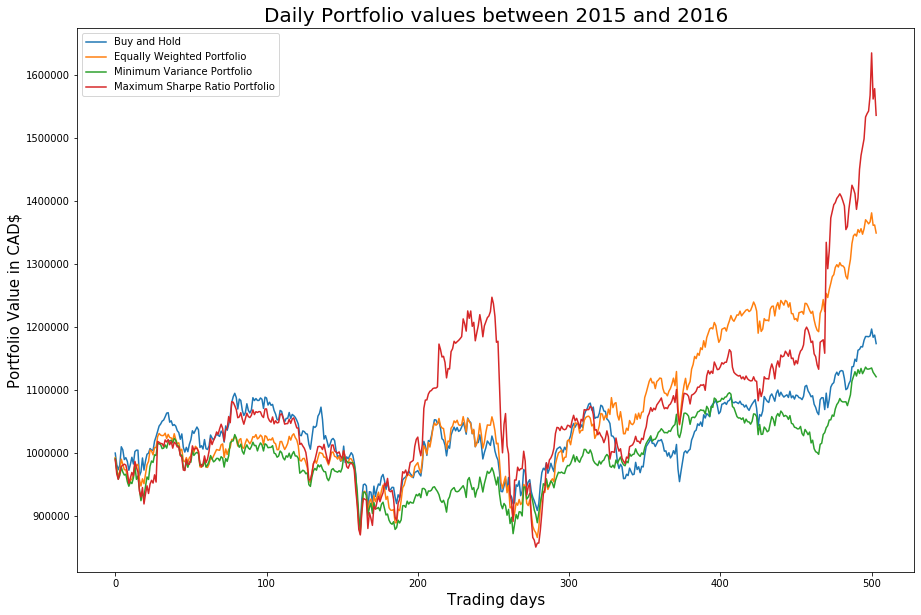

In [330]:
day_ind_start_CHECK = []
day_ind_end_CHECK = []
p_values_CHECK =[]
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)
    
    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    # The code below has no meaning but check the day_ind_start
    day_ind_start_CHECK.append(day_ind_start)
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    # The code below has no meaning but check the dat_end_start
    day_ind_end_CHECK.append(day_ind_end)
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
    for strategy in range(N_strat):# Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1)) # 504 x 1 zeros
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

      # Compute strategy
        x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1]= fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
        if cash[strategy][period-1]<0:
            # Portfolio value before balancing
            portfolio_value = np.sum(curr_positions * cur_prices) + curr_cash
            # Current weeight distribution
            ratio = x[strategy][period-1]/np.sum(x[strategy, period-1])
            # Distribute over-draft cash by weight to each stock
            cash_excess = abs(cash[strategy, period-1])* ratio
            #Determine the number of excess shares bought for each stock
            position_excess = np.ceil(cash_excess/cur_prices)
            #Recalculate optimal position of stocks by substracting excess shares bought
            x[strategy, period-1] = x[strategy][period-1] - position_excess
            transaction_cost = np.dot(cur_prices, abs(x[strategy, period-1] - curr_positions))*0.005
            cash[strategy, period-1] = portfolio_value - np.sum(cur_prices * x[strategy][period-1]) - transaction_cost
      
    # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        p_values_CHECK.append(p_values)
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results
plt.rcParams['figure.figsize'] = [15, 10]
plt.plot(portf_value[0], label = 'Buy and Hold')
plt.plot(portf_value[1], label = 'Equally Weighted Portfolio')
plt.plot(portf_value[2], label = 'Minimum Variance Portfolio')
plt.plot(portf_value[3], label = 'Maximum Sharpe Ratio Portfolio')
plt.legend()
plt.ylabel('Portfolio Value in CAD$', fontsize=15)
plt.xlabel('Trading days', fontsize=15)
plt.title('Daily Portfolio values between 2015 and 2016', fontsize= 20)
plt.show()


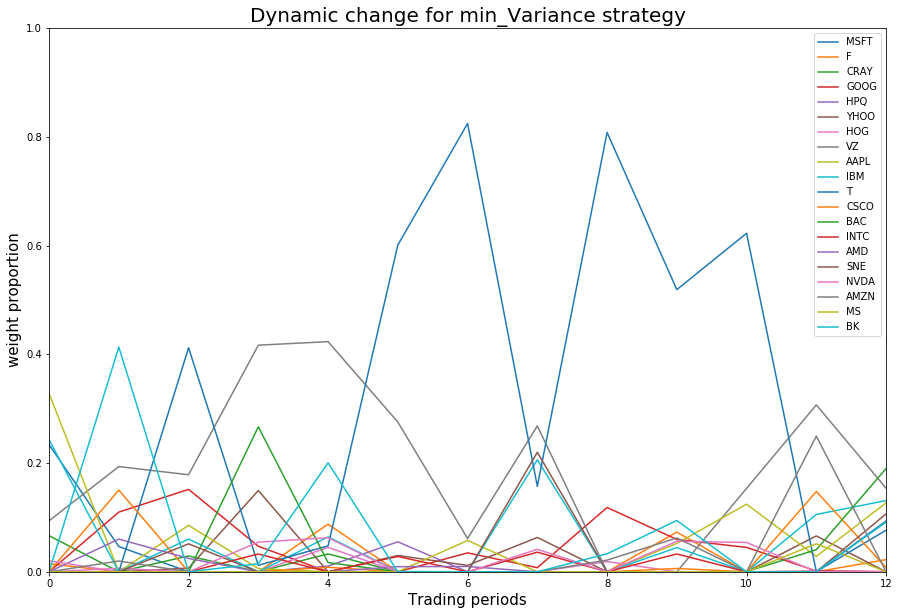

In [331]:
#Dynamic change for min_Variance strategy

names = list(df.columns.values)
stock_names = names[1:]
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])
init_price = init_positions * data_prices[0,:]
init_value = np.dot(data_prices[0,:], init_positions)
w_initial = init_price / init_value

for i in range(20):
    stock_weight =[w_initial[i]]
    period = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    for j in range(12):
        stock_weight.append(weight[2][j][i])
    plt.plot(period,stock_weight, label = stock_names[i])
plt.legend()
plt.ylim([0,1])
plt.xlim([0,12])

plt.ylabel('weight proportion', fontsize=15);
plt.xlabel('Trading periods', fontsize=15);
plt.title('Dynamic change for min_Variance strategy', fontsize = 20);
plt.savefig('min_Variance_dynamic_change.png')

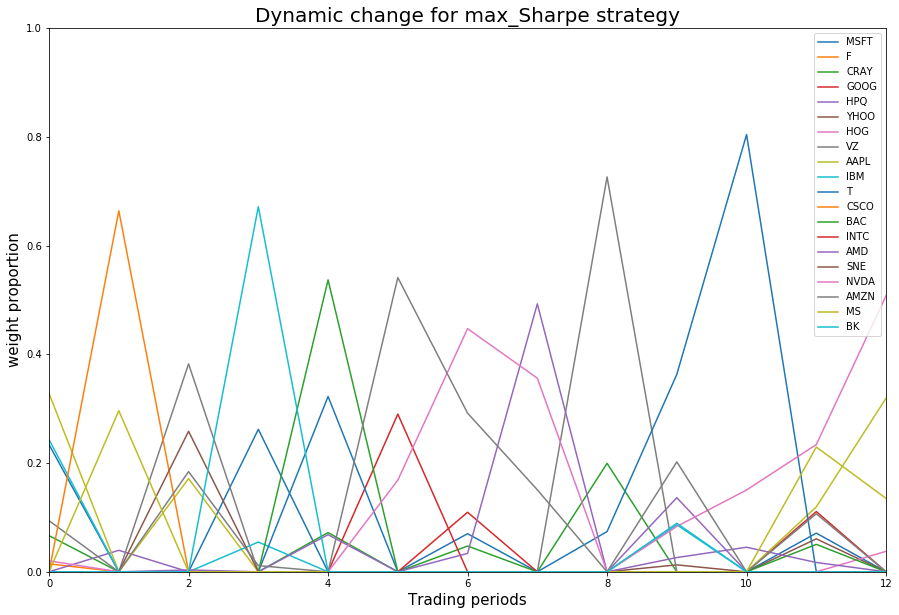

In [341]:
#Dynamic change for max_Sharpe ratio strategy

names = list(df.columns.values)
stock_names = names[1:]
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])
init_price = init_positions * data_prices[0,:]
init_value = np.dot(data_prices[0,:], init_positions)
w_initial = init_price / init_value

for i in range(20):
    stock_weight =[w_initial[i]]
    period = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    for j in range(12):
        stock_weight.append(weight[3][j][i])
    plt.plot(period,stock_weight, label = stock_names[i])
plt.legend()
plt.ylim([0,1])
plt.xlim([0,12])

plt.ylabel('weight proportion', fontsize=15);
plt.xlabel('Trading periods', fontsize=15);
plt.title('Dynamic change for max_Sharpe strategy', fontsize = 20);
plt.savefig('max_Sharperatio_dynamic_change.png')